In [1]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np
import time

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import r2_score

import plotly.express as px
import TsModel
import GprModel
from sklearn.utils import validation
from windrose import WindroseAxes
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.path import Path
from matplotlib.transforms import Affine2D
from matplotlib.patches import Circle, RegularPolygon

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
plt.rcParams.update({'font.size': 18})

In [3]:
# Source: From the TSmodel
def preprocess_data(train, validation):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    validation_data = scaler.transform(validation)
    
    return train_data, validation_data

In [4]:
# Modified from source: https://blog.paperspace.com/svr-kmeans-clustering-for-regression/#implementing-k-means-clustering-svr
def kmeans_model(X_train, Y_train, n_clusters=30):
    
    kmeans = KMeans(
    init="random",
    n_clusters=n_clusters,
    max_iter=300)
    
    # Fit to the training data
    kmeans.fit(X_train)
    # Generate out clusters
    train_cluster = kmeans.predict(X_train)
    
    cluster_predictors = []

    for i in range(n_clusters):
        index = np.where(train_cluster == i)[0]
        cluster_X = X_train[index]
        cluster_Y = Y_train[index]
        model = LinearRegression()
        cluster_predictors.append(model.fit(cluster_X, cluster_Y))
    
    return kmeans, cluster_predictors

def regression_function(X_test, kmeans, cluster_svr):
    result = []
    clusters_pred = kmeans.predict(X_test)
    for i,data in enumerate(X_test):
        result.append(((cluster_svr[clusters_pred[i]]).predict([data]))[0])
    return result,clusters_pred

In [14]:
# hyperparameters for the expeirment
# This experiment is completed until 10 stations

number_of_neighbour_stations = [1,2,3,4,5,6,7,8,9, 10,11,12]

# Expeirment related parameters
number_of_folds = 10 # have to be 10 fold

# Results containers
training_results_kmeans_min_feature = []
test_results_kmeans_min_feature = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values):    
    for hyperparameter_value in hyper_parameter_to_test_values:
        # Station data is generated already, only need to train the model
        flatten_train_x = pd.read_csv(f"Data/exp/{hyperparameter_value}x.csv", index_col=0).to_numpy()
        flatten_train_y = pd.read_csv(f"Data/exp/{hyperparameter_value}y.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)

        # Test data should still need to be generated
        flatten_test_x = pd.read_csv(f"Data/exp/{hyperparameter_value}x_test.csv", index_col=0).to_numpy()
        flatten_test_y = pd.read_csv(f"Data/exp/{hyperparameter_value}y_test.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)

        # After all data are ready, do a 10 fold cross validation
        training_results_fold = []
        test_results_fold = []
            
        for i in range(0, number_of_folds):
            flatten_train_x, flatten_train_y = shuffle(flatten_train_x, flatten_train_y)
    
            flatten_train_x = np.asarray(flatten_train_x).astype('float32')
            flatten_train_y = np.asarray(flatten_train_y).astype('float32')
            flatten_test_x = np.asarray(flatten_test_x).astype('float32')
            flatten_test_y = np.asarray(flatten_test_y).astype('float32')
            
            print(f"Currently running fold {i} for {hyperparameter_value} stations")

            # Normalize the input
            norm_flatten_train_x, norm_flatten_test_x = preprocess_data(flatten_train_x, flatten_test_x)            
         
             # Kmeans
            kmeans, k_means_models = kmeans_model(norm_flatten_train_x, flatten_train_y, n_clusters=30)
            result,clusters = regression_function(norm_flatten_train_x, kmeans, k_means_models)
            kmeans_train_rmse = mean_squared_error(result, flatten_train_y, squared=False)
            training_results_fold.append({'kmeans_train' : kmeans_train_rmse})
            
            result,clusters = regression_function(norm_flatten_test_x, kmeans, k_means_models)
            kmeans_test_rmse = mean_squared_error(result, flatten_test_y, squared=False)
            test_results_fold.append({'kmeans_test' : kmeans_test_rmse})
            
        #After all folds are done, update the result containers
        training_results_kmeans_min_feature.append(training_results_fold)
        test_results_kmeans_min_feature.append(test_results_fold)
        

In [15]:
do_experiment(number_of_neighbour_stations)

Currently running fold 0 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [4]:
# Save the current experiment result and resume when needed
# Modified from source: https://stackoverflow.com/questions/34342155/how-to-pickle-or-store-jupyter-ipython-notebook-session-for-later

# training_results_single_feature = training_results
# test_results_single_feature = test_results

# %store training_results_li_ts_km_nn_min_feature
# %store test_results_li_ts_km_nn_min_feature

#closing seesion, restarting kernel

%store -r training_results_li_ts_km_nn_min_feature
%store -r test_results_li_ts_km_nn_min_feature

exp
exp li train
7.3231000900268555±0.0
exp nn train
7.1188±0.0053
exp fcm train
7.0517±0.0079
exp kmeans train
7.0447001457214355±0.013899999670684338
exp
exp li train
7.1732001304626465±0.0
exp nn train
6.4136±0.0318
exp fcm train
6.4676±0.0128
exp kmeans train
6.420199871063232±0.03139999881386757
exp
exp li train
7.019700050354004±0.0
exp nn train
5.9383±0.0099
exp fcm train
6.0519±0.0073
exp kmeans train
6.0756001472473145±0.021700000390410423
exp
exp li train
6.906799793243408±0.0
exp nn train
5.7758±0.0036
exp fcm train
5.8533±0.0088
exp kmeans train
5.875699996948242±0.010599999688565731
exp
exp li train
6.777200222015381±0.0
exp nn train
5.7107±0.0026
exp fcm train
5.7927±0.0087
exp kmeans train
5.796599864959717±0.012299999594688416
exp
exp li train
6.840400218963623±0.0
exp nn train
5.674±0.0051
exp fcm train
5.7047±0.0051
exp kmeans train
5.750500202178955±0.011500000022351742
exp
exp li train
6.932799816131592±0.0
exp nn train
5.6383±0.0047
exp fcm train
5.6778±0.0087
exp 

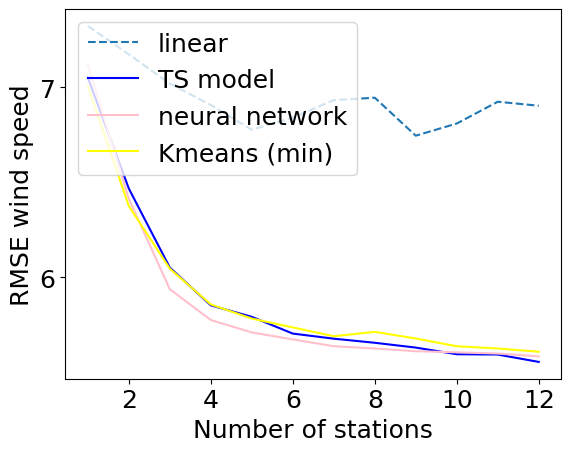

In [5]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
kmeans_train_plot = []
x_axis =  [1,2,3,4,5,6,7,8,9, 10,11,12]

for exp in training_results_li_ts_km_nn_min_feature:
     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))
     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
     kmeans_train_plot.append(np.min([d['kmeans_train'] for d in exp if 'kmeans_train' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.plot(x_axis, kmeans_train_plot, label='Kmeans (min)', c='yellow')

plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
#plt.title('RMSE wind speed vs number of stations on training data')

for exp in training_results_li_ts_km_nn_min_feature:
    print('exp')
    print('exp li train')
    print(f"{np.round(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]), 4)}±{np.round(np.std([d['linear_train'] for d in exp if 'linear_train' in d]),4)}")
    print('exp nn train')
    print(f"{np.round(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]), 4)}±{np.round(np.std([d['nn_train'] for d in exp if 'nn_train' in d]),4)}")
    print('exp fcm train')
    print(f"{np.round(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]), 4)}±{np.round(np.std([d['fcm_train'] for d in exp if 'fcm_train' in d]),4)}")
    print('exp kmeans train')
    print(f"{np.round(np.mean([d['kmeans_train'] for d in exp if 'kmeans_train' in d]), 4)}±{np.round(np.std([d['kmeans_train'] for d in exp if 'kmeans_train' in d]),4)}")

  

exp
exp li test
7.332799911499023±0.0
exp nn test
7.123±0.0051
exp fcm test
7.0657±0.0085
exp kmeans test
7.058599948883057±0.014600000344216824
exp
exp li test
7.180799961090088±0.0
exp nn test
6.4±0.0313
exp fcm test
6.4703±0.0145
exp kmeans test
6.428599834442139±0.032099999487400055
exp
exp li test
7.0304999351501465±0.0
exp nn test
5.9292±0.0098
exp fcm test
6.0618±0.0077
exp kmeans test
6.087699890136719±0.020999999716877937
exp
exp li test
6.915299892425537±0.0
exp nn test
5.7671±0.0033
exp fcm test
5.8669±0.0092
exp kmeans test
340.2807922363281±823.5894165039062
exp
exp li test
6.783999919891357±0.0
exp nn test
5.6984±0.0025
exp fcm test
5.8032±0.0092
exp kmeans test
178.58889770507812±428.5433044433594
exp
exp li test
6.853300094604492±0.0
exp nn test
5.669±0.0064
exp fcm test
5.7258±0.0047
exp kmeans test
111.58470153808594±221.19520568847656
exp
exp li test
6.934899806976318±0.0
exp nn test
5.6361±0.0056
exp fcm test
5.6916±0.0088
exp kmeans test
47.60060119628906±110.80229

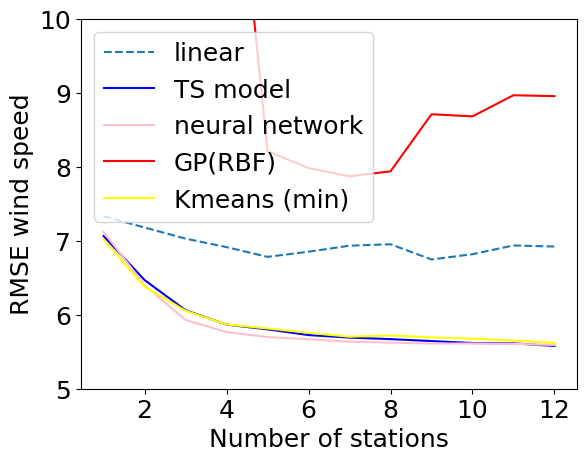

In [10]:
# The fcm testing data is MSE not RMSE

li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
kmeans_train_plot= []
gpr_plot = []
x_axis =  [1,2,3,4,5,6,7,8,9, 10,11,12]
for exp in test_results_li_ts_km_nn_min_feature:
     li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
     gpr_plot.append(np.mean([d['gpr_test'] for d in exp if 'gpr_test' in d]))
     nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))
     fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))
     kmeans_train_plot.append(np.min([d['kmeans_test'] for d in exp if 'kmeans_test' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.plot(x_axis, gpr_plot, label='GP(RBF)', c='red')
plt.plot(x_axis, kmeans_train_plot, label='Kmeans (min)', c='yellow')

plt.legend(loc="upper left")
plt.ylim(5,10)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
#plt.title('RMSE wind speed vs number of stations on testing data')

for exp in test_results_li_ts_km_nn_min_feature:
    print('exp')
    print('exp li test')
    print(f"{np.round(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]), 4)}±{np.round(np.std([d['linear_test'] for d in exp if 'linear_test' in d]),4)}")
    print('exp nn test')
    print(f"{np.round(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]), 4)}±{np.round(np.std([d['nn_test'] for d in exp if 'nn_test' in d]),4)}")
    print('exp fcm test')
    print(f"{np.round(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]), 4)}±{np.round(np.std([d['fcm_test'] for d in exp if 'fcm_test' in d]),4)}")
    print('exp kmeans test')
    print(f"{np.round(np.mean([d['kmeans_test'] for d in exp if 'kmeans_test' in d]), 4)}±{np.round(np.std([d['kmeans_test'] for d in exp if 'kmeans_test' in d]),4)}")

